In [1]:
!pip install tflearn

In [2]:
import nltk
nltk.download('punkt')
from nltk.stem.lancaster import LancasterStemmer
import numpy as np
import tensorflow as tflow
import tflearn
import random
import json
import pickle
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Instructions for updating:
non-resource variables are not supported in the long term


# **DATA PRE-PROCESSING**
pattern = questions

tag = type of question

response = answer of pattern

In [3]:
stemmer = LancasterStemmer()

# accessing the json file that has the questions and answerss
with open("dataset.json") as file:
    data = json.load(file)

#print(data)
#print(data["intents"])

In [4]:
labels = [] # tag labels we used
docs_x = [] # for each word in pattern/question in docs_x we have
docs_y = [] # the intent tag it has in docs_y
x_test =[]
y_test = []

# tokenizing the words of the statements
for intent in data["intents"]: 
              for pattern in range (len(intent["patterns"])): 
                  words = nltk.word_tokenize(intent["patterns"][pattern]) 
                  words = [stemmer.stem(w.lower()) for w in words if w!= "?"] #takes the pattern words and sets them to small caps for equal consideration
                  docs_x.append(words)        
                  docs_y.append(intent["tag"])

              w = intent["patterns"][-1]  
              words = nltk.word_tokenize(w)  
              w = [stemmer.stem(a.lower()) for a in words if a!= "?"] 
              x_test.append(w) 
              y_test.append(intent["tag"]) 
              
              if intent["tag"] not in labels:
                  labels.append(intent["tag"])

print(x_test) 
print(y_test)
#print(docs_x)
labels = sorted(labels)
#print(docs_y)
#print(labels)


[['hey'], ['how', 'ar', 'you', 'doing'], ['peac'], ['what', 'yo', 'nam'], ['can', 'i', 'ask', 'you', 'any', 'quest'], ['okay', 'thank', 'you', '!'], ['what', 'is', 'the', 'proc', 'for', 'obtain', 'a', 'min'], ['when', 'do', 'we', 'apply', 'for', 'for', 'fin', 'aid'], ['what', 'tim', 'doe', 'jafet', 'libr', 'us', 'op'], ['wher', 'can', 'i', 'access', 'the', 'fin', 'aid', 'apply'], ['is', 'ther', 'an', 'opt', 'to', 'get', 'the', 'academ', 'transcrib', 'as', 'a', 'pdf'], ['how', 'do', 'i', 'get', 'a', 'soft', 'cop', 'of', 'my', 'academ', 'transcrib'], ['what', 'doe', 'overal', 'gpa', 'mean'], ['could', 'i', 'request', 'onlin', 'the', 'academ', 'transcrib', 'and', 'how'], ['print', 'my', 'acadm', 'transcrib'], ['a', 'cours', 'was', 'remov', 'from', 'my', 'academ', 'transcrib'], ['how', 'do', 'i', 'contact', 'to', 'ord', 'an', 'offf', 'academ', 'transcrib'], ['i', 'hav', 'a', 'problem', 'with', 'my', 'academ', 'transcrib', ',', 'who', 'should', 'i', 'contact'], ['wher', 'can', 'i', 'view', 

In [5]:

#Tokenizing all words in training set: used to update the internal vocabulary for the texts list/turns each word into a vector of numbers
vocabulary_size = 30
tokenizer = Tokenizer(num_words = vocabulary_size)
tokenizer.fit_on_texts(docs_x)
sequences = tokenizer.texts_to_sequences(docs_x)

output = []
y_test_bow =[]
out_empty = [0 for _ in range(len(labels))]

for x, doc in enumerate(docs_x):
        output_row = out_empty[:]
        output_row[labels.index(docs_y[x])] = 1     # we look through our used tags and set it to 1 in ouput_row
        output.append(output_row)                   # output data

for x, doc in enumerate(y_test): #here
        output_row = out_empty[:] #here
        output_row[labels.index(y_test[x])] = 1  #here    # we look through our used tags and set it to 1 in ouput_row
        y_test_bow.append(output_row) #here

training = pad_sequences(sequences, maxlen=50) #makes sure all sentences have the same size
#print(training)
y_test = np.array(y_test_bow)
print(y_test)
output = np.array(output)
#print(output)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


In [6]:
sequences = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(sequences, maxlen=50)
print(x_test)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 10 13]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  5 27 28]
 [ 0  0  0 ... 27 28  7]
 [ 0  0  0 ...  2 27 28]]


In [7]:
#trying an example for tokenizer
s = "Where can I add"
s_words = nltk.word_tokenize(s)
print(s_words)
s_words = [stemmer.stem(word.lower()) for word in s_words]
s_words =[s_words]
print(s_words)
sequences = tokenizer.texts_to_sequences(s_words)
x = [pad_sequences(sequences, maxlen=20)]
  

['Where', 'can', 'I', 'add']
[['wher', 'can', 'i', 'ad']]


# MODEL TRAINING

In [8]:
# tensorflow and tflearn model
from keras.models import Sequential
from keras.layers.recurrent import LSTM,SimpleRNN
from keras.losses import cosine_similarity
from keras.layers import Dropout, Dense, BatchNormalization

model = Sequential()
model.add(Embedding(30, 100, input_length=50))
model.add(LSTM(training.shape[1], return_sequences=True))
model.add(BatchNormalization())

model.add(LSTM(350, return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(LSTM(250))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(output.shape[1], activation='softmax'))
model.add(Dropout(0.2))


model.compile(loss = 'cosine_similarity', optimizer = 'adam', metrics = ['accuracy'] )


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Colocations handled automatically by placer.


In [9]:
output.shape

(303, 44)

In [10]:
history = model.fit(training, output,batch_size= 317,epochs = 550, validation_data = (x_test,y_test),verbose = 1, shuffle = True)

model.save("model.tflearn")


Train on 303 samples, validate on 45 samples
Epoch 1/550
303/303 [==============================] - ETA: 0s - loss: -0.0812 - acc: 0.0330

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


303/303 [==============================] - 7s 22ms/sample - loss: -0.0812 - acc: 0.0330 - val_loss: -0.1508 - val_acc: 0.0222
Epoch 2/550
303/303 [==============================] - 5s 15ms/sample - loss: -0.1721 - acc: 0.1320 - val_loss: -0.1508 - val_acc: 0.0222
Epoch 3/550
303/303 [==============================] - 5s 16ms/sample - loss: -0.2316 - acc: 0.1881 - val_loss: -0.1509 - val_acc: 0.0222
Epoch 4/550
303/303 [==============================] - 5s 15ms/sample - loss: -0.3036 - acc: 0.2541 - val_loss: -0.1509 - val_acc: 0.0222
Epoch 5/550
303/303 [==============================] - 4s 15ms/sample - loss: -0.3177 - acc: 0.2706 - val_loss: -0.1509 - val_acc: 0.0222
Epoch 6/550
303/303 [==============================] - 4s 15ms/sample - loss: -0.3762 - acc: 0.3201 - val_loss: -0.1510 - val_acc: 0.0222
Epoch 7/550
303/303 [==============================] - 5s 15ms/sample - loss: -0.3964 - acc: 0.3597 - val_loss: -0.1510 - val_acc: 0.0222
Epoch 8/550
303/303 [=========================

In [11]:
y_pred = np.argmax(model.predict(x_test), axis=1) 
print(y_pred)
print(np.argmax(y_test, axis=1)) 
from sklearn.metrics import classification_report 
print(classification_report(np.argmax(y_test, axis=1), y_pred)) 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[29 30 29 30 29 29 32 28  3 24 15 17 30 11 12 13 14 16 19 22 24 25 26 20
 26 23 18  1  3  2  2  3  3 34 35 36 37 29 29 29 40 39 41 42 43]
[30 27 29 33 31 38 32 28  0 24 15 17 18 11 12 13 14 16 19 22 24 25 26 20
 21 23  1  5  6  7  2  3  4 34 35 36 37  8  9 10 40 39 41 42 43]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.50      1.00      0.67         1
           3       0.25      1.00      0.40         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         1
          12       1.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
from sklearn.metrics import accuracy_score

print(accuracy_score(np.argmax(y_test, axis=1), y_pred, normalize=False))

29


In [13]:
print(f"Final loss: {history.history['loss'][-1]}")

Final loss: -0.7157026529312134


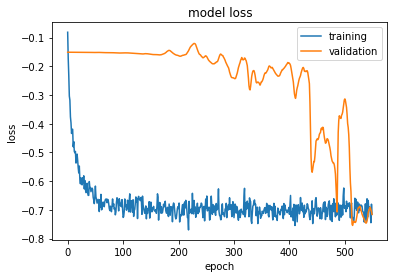

In [14]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

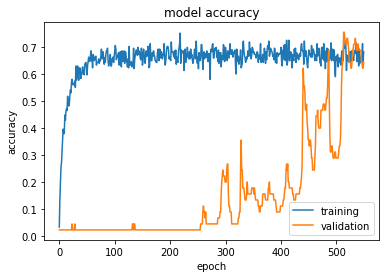

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

In [17]:
# function that bags the user input words, and changes them into numpy arrays for use for model
from tensorflow.python.util import deprecation

def preprocess(s, words):
    s_words = nltk.word_tokenize(s)
    s_words = [[stemmer.stem(word.lower()) for word in s_words]]
    sequences = tokenizer.texts_to_sequences(s_words)
    return pad_sequences(sequences, maxlen=50)

#function to start chatting with the bot/model
def chat():
    print("Start talking with AUBot (type quit to stop)!")

    while True:
        inp = input("\nYou: ")
        if inp.lower() == "quit":
            break

        x = ([preprocess(inp,words)])
        #print(x)
        results = model.predict(x)  #classifies the input into a probability array of what tag it should be
        #print(results)
        results_index = np.argmax(results)  # index of highest probabile tag
        tag = labels[results_index]
        #print(tag)
        print("\nAUBot:")
        for tg in data["intents"]:
            if tg['tag'] == tag:
                responses = tg['responses']
        
        print(random.choice(responses))  
        deprecation._PRINT_DEPRECATION_WARNINGS = False
chat()


Start talking with AUBot (type quit to stop)!

You: what's up?

AUBot:
Hello! how are doing today?

You: how are you doing?

AUBot:
Hello! how are doing today?

You: what's your name?

AUBot:
Good to see you again!

You: what are you?

AUBot:
Hi there, how can I help?

You: What does a negative value mean on the web statement of fees?

AUBot:
Fall Courses Discount (Financial Aid). Note that this is not the finalized Web Statement of fees.

You: does financial aid cover the summer semester?

AUBot:
If you ask nicely maybe 

You: when does the registrar open?

AUBot:
You have to take an appointment if it's not an emergency case. Call ext. 3000

You: how do I submit a petition

AUBot:
Google 'aub petitions' and it should be the first link you see

You: my web statement of fees is not updated although I paid

AUBot:
Contact Comptroller's Office at Ext. 2473-2980, or by email at compt_sas@aub.edu.lb

You: how do I get payment from the work study program

AUBot:
The aub office sends an email